# Predict Future Sales
from [kaggle competition](https://www.kaggle.com/c/competitive-data-science-predict-future-sales/)

## 2. EDA and Feature Engineering


## 2-1. Data optimization

In [1]:
import pandas as pd
from matplotlib import pyplot as plt

train = pd.read_csv('data/sales_train_opt_ver1.csv')

In [2]:
# optimize dataset
train.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1609124 entries, 0 to 1609123
Data columns (total 16 columns):
shop_id                          1609124 non-null int64
item_id                          1609124 non-null int64
date_block_num                   1609124 non-null int64
item_cnt_month                   1609124 non-null float64
item_price_month                 1609124 non-null float64
date_month                       1609124 non-null int64
date_year                        1609124 non-null int64
item_cateogory_id                1609124 non-null int64
shop_loc                         1609124 non-null object
shop_loc_dist                    1574025 non-null object
shop_loc_pop_2010                1574025 non-null float64
shop_loc_pop_2017                1574025 non-null float64
shop_loc_pop_rank_2017           1574025 non-null float64
shop_loc_pop_change_2010_2017    1574025 non-null float64
item_first_category              1609124 non-null object
item_second_category            

### Optimization Scheme


Columns to drop
* We are to predict the sales in `Nov. 2015` - we are supposed to use data only available at the point before `Oct. 2015`
  * `shop_loc_pop_2017`, `shop_loc_pop_rank_2017`, `shop_loc_pop_change_2010_2017`
* `item_category_id` represents categorized information including `item_second_category` already
  * `item_second_category`

Columns to optimize numerical size : only columns that need be applied by some arithmetic
  * optimize as `float` type : `item_price_month`, `shop_loc_pop_2010`
  * convert to `integer` and optimize : `item_cnt_month`, `date_block_num`, `date_month`, `date_year`
  
Columns to convert to `category` type
* Convert the columns below if `len(len_of_unique_values) < .5 * total_length_of_rows`
* `_id`, `_category`, `shop_loc`, `shop_loc_dist`

In [3]:
train.head()

,shop_id,item_id,date_block_num,item_cnt_month,item_price_month,date_month,date_year,item_cateogory_id,shop_loc,shop_loc_dist,shop_loc_pop_2010,shop_loc_pop_2017,shop_loc_pop_rank_2017,shop_loc_pop_change_2010_2017,item_first_category,item_second_category
0,0,30,1,31.0,265.0,2,2013,40,yakutsk,Far East,269601.0,307911.0,64.0,14.2,cinema,dvd
1,0,31,1,11.0,434.0,2,2013,37,yakutsk,Far East,269601.0,307911.0,64.0,14.2,cinema,blu-ray
2,0,32,0,6.0,221.0,1,2013,40,yakutsk,Far East,269601.0,307911.0,64.0,14.2,cinema,dvd
3,0,32,1,10.0,221.0,2,2013,40,yakutsk,Far East,269601.0,307911.0,64.0,14.2,cinema,dvd
4,0,33,0,3.0,347.0,1,2013,37,yakutsk,Far East,269601.0,307911.0,64.0,14.2,cinema,blu-ray


In [4]:
# correct spell; `item_cateogory_id` -> `item_category_id`
original_colnames = train.columns.tolist()
modified_colnames = original_colnames[:]
modified_colnames[modified_colnames.index('item_cateogory_id')] = 'item_category_id'
org_mod_colnames_mapped = dict(zip(original_colnames, modified_colnames))
train = train.rename(columns=org_mod_colnames_mapped)

print(train.columns.tolist())

['shop_id', 'item_id', 'date_block_num', 'item_cnt_month', 'item_price_month', 'date_month', 'date_year', 'item_category_id', 'shop_loc', 'shop_loc_dist', 'shop_loc_pop_2010', 'shop_loc_pop_2017', 'shop_loc_pop_rank_2017', 'shop_loc_pop_change_2010_2017', 'item_first_category', 'item_second_category']


In [5]:
cols_to_drop = ['shop_loc_pop_2017', 'shop_loc_pop_rank_2017', 'shop_loc_pop_change_2010_2017', 'item_second_category']
train = train.drop(cols_to_drop, axis=1)

In [6]:
cols_to_cat = ['shop_id', 'item_id', 'item_category_id',
              'shop_loc', 'shop_loc_dist', 'item_first_category']

for cc in cols_to_cat:
    if len(train[cc].unique()) < .5 * len(train):
        train[cc] = train[cc].astype('category')

In [7]:
cols_to_optfloat = ['item_price_month', 'shop_loc_pop_2010']
for fc in cols_to_optfloat:    
    train[fc] = pd.to_numeric(train[fc], downcast='float')

In [8]:
cols_to_optint = ['date_block_num', 'date_month', 'date_year', 'item_cnt_month']

for ic in cols_to_optint:
    train[ic] = pd.to_numeric(train[ic].astype('int'),
                                        downcast='integer')

In [9]:
# optimization finished: 
# FROM 544MB TO 33MB
train.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1609124 entries, 0 to 1609123
Data columns (total 12 columns):
shop_id                1609124 non-null category
item_id                1609124 non-null category
date_block_num         1609124 non-null int8
item_cnt_month         1609124 non-null int16
item_price_month       1609124 non-null float32
date_month             1609124 non-null int8
date_year              1609124 non-null int16
item_category_id       1609124 non-null category
shop_loc               1609124 non-null category
shop_loc_dist          1574025 non-null category
shop_loc_pop_2010      1574025 non-null float32
item_first_category    1609124 non-null category
dtypes: category(6), float32(2), int16(2), int8(2)
memory usage: 33.0 MB


### `null` values exist in column `shop_loc_dist` and `shop_loc_pop_2010`
* where `shop_loc` is `online` or `export`
  * we will treat the null values before modeling process.

In [10]:
# additionally create 'season' column for some products having seasonality.

month_season_mapped = {
    1:'winter', 2:'winter',
    3:'spring', 4:'spring', 5:'spring',
    6:'summer', 7:'summer', 8:'summer', 
    9:'autumn', 10:'autumn', 11:'autumn',
    12:'winter'
}

train['date_season'] = train['date_month'].map(month_season_mapped)

In [11]:
# to visualize the actual income, 
train['revenue_month'] = train['item_price_month'] * train['item_cnt_month']

In [12]:
train.head()

,shop_id,item_id,date_block_num,item_cnt_month,item_price_month,date_month,date_year,item_category_id,shop_loc,shop_loc_dist,shop_loc_pop_2010,item_first_category,date_season,revenue_month
0,0,30,1,31,265.0,2,2013,40,yakutsk,Far East,269601.0,cinema,winter,8215.0
1,0,31,1,11,434.0,2,2013,37,yakutsk,Far East,269601.0,cinema,winter,4774.0
2,0,32,0,6,221.0,1,2013,40,yakutsk,Far East,269601.0,cinema,winter,1326.0
3,0,32,1,10,221.0,2,2013,40,yakutsk,Far East,269601.0,cinema,winter,2210.0
4,0,33,0,3,347.0,1,2013,37,yakutsk,Far East,269601.0,cinema,winter,1041.0


## Total revenue by year
note : not fully represent the whole year's revenue data.
* `2013.01-2013.12`
* `2014.01-2014.12`
* `2015.01-2015.10`

### Significant amount of revenues might have been occurring in last two month (`Nov` and `Dec`) .

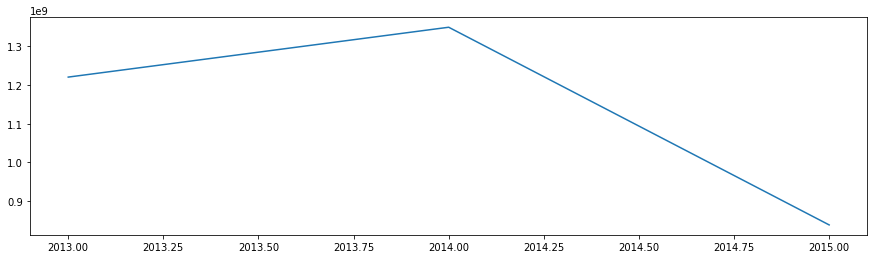

In [106]:
plt.figure(figsize=(15,4))
plt.plot([2013,2014,2015], [train[train['date_year']==year]['revenue_month'].sum() for year in [2013, 2014, 2015]])
plt.show()

## Total revenue by `date_block_num`
* `0` at x axis = `Jan 2013`
* `33` at x axis = `Oct 2015`

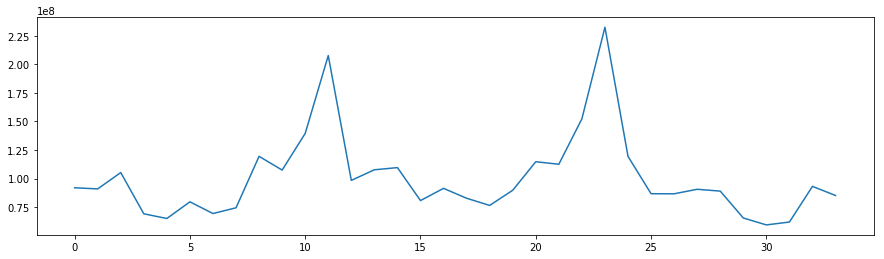

In [104]:
plt.figure(figsize=(15, 4))
plt.plot(sorted(train['date_block_num'].unique()), train.groupby('date_block_num')['revenue_month'].sum())
plt.show()

## Total revenue by `date_month`

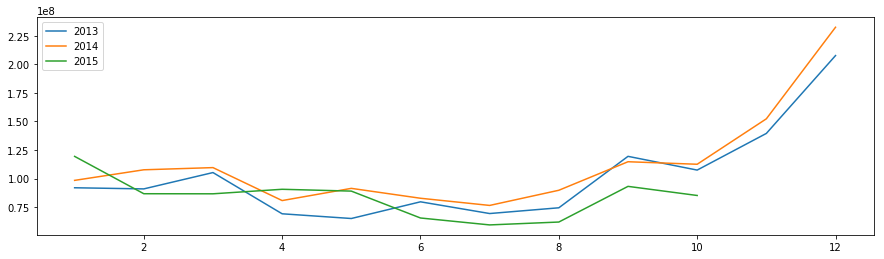

In [108]:
rev_2013_by_month = train[train['date_year']==2013].groupby('date_month')['revenue_month'].sum()
rev_2014_by_month = train[train['date_year']==2014].groupby('date_month')['revenue_month'].sum()
rev_2015_by_month = train[train['date_year']==2015].groupby('date_month')['revenue_month'].sum()

plt.figure(figsize=(15,4))
plt.plot(range(1,13), rev_2013_by_month, label='2013')
plt.plot(range(1,13), rev_2014_by_month, label='2014')
plt.plot(range(1,11), rev_2015_by_month, label='2015')
plt.legend()
plt.show()

## If comparing total revenue from only `Jan` to `Oct` for year `2013`, `2014` and `2015`

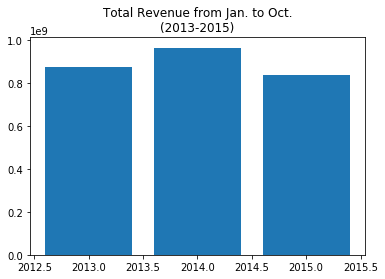

In [55]:
plt.bar([2013,2014,2015], height=[sum(rev_2013_by_month[:10]), sum(rev_2014_by_month[:10]), sum(rev_2015_by_month)])
plt.title('Total Revenue from Jan. to Oct.\n(2013-2015)')
plt.show()

## What happend in Russia of `2015`?

* In `2015`, the total revenue before `Nov` - winter season - decreased relatively.
* From the national economy indices, we can guess the decrease in revenue due to the economical depression.

SOURCE : https://www.focus-economics.com/countries/russia

![russia-economy-indices](data/russia-economy.png)


## Visualize `Revenue in Jan-Oct` with economic index

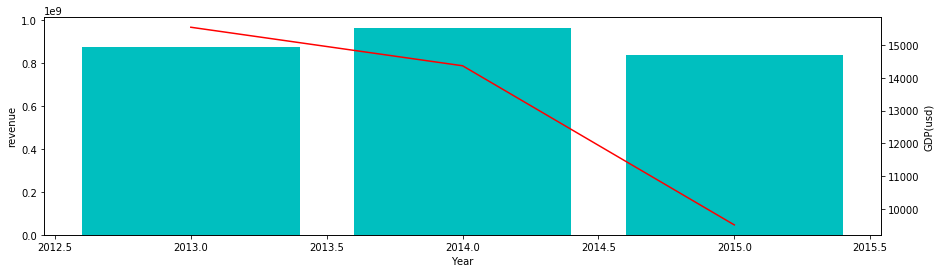

In [112]:
import numpy
def two_scales(ax1, time, data1, data2, c1, c2):
    ax2 = ax1.twinx()

    ax1.bar(time, height=data1, color=c1)
    ax2.plot(time, data2, color=c2)
    
    return ax1, ax2

# Create axes
fig, ax = plt.subplots()
fig.set_figwidth(15)
fig.set_figheight(4)
ax1, ax2 = two_scales(ax, [2013, 2014, 2015], 
                      [sum(rev_2013_by_month[:10]), sum(rev_2014_by_month[:10]), sum(rev_2015_by_month)],
                      [15553, 14374, 9503], 'c', 'r')
ax1.set_xlabel('Year')
ax1.set_ylabel('revenue')
ax2.set_ylabel('GDP(usd)')

plt.show()

In [14]:
# economic index list (in order)
# economic indices tend to be correlated highly.
# we will choose the best feature out of the economic indices.

# gdp_per_capita_usd
# economic_growth_perc
# consumption_perc
# retail_sales_perc
# unemployment_rate
# inflation_rate_cpi_perc
# inflation_rate_ppi_perc

years = [2013, 2014, 2015]
gdp_per_capita_usd = [15553, 14374, 9503]
economic_growth_perc = [1.3, 0.7, -2.8]
consumption_perc = [4.4, 2.0, -9.8]
retail_sales_perc = [3.9, 2.7, -9.8]
unemployment_rate = [5.5, 5.2, 5.6]
inflation_rate_cpi_perc = [6.8, 7.8, 15.5]
inflation_rate_ppi_perc = [3.7, 5.9, 10.7]

eco_indices_names = ['gdp_per_capita_usd', 'economic_growth_perc',
                    'consumption_growth_perc', 'retail_sales_perc',
                    'unemployment_rate', 'inflation_rate_cpi_perc',
                    'inflation_rate_ppi_perc']
eco_indices_values = [
    [15553, 14374, 9503],
    [1.3, 0.7, -2.8],
    [4.4, 2.0, -9.8],
    [3.9, 2.7, -9.8],
    [5.5, 5.2, 5.6],
    [6.8, 7.8, 15.5],
    [3.7, 5.9, 10.7]
]


for i, indexname in enumerate(eco_indices_names):
    
    train[indexname] = train['date_year'].map(dict(zip(years,
                                                      eco_indices_values[i])))



In [15]:
train.head()

,shop_id,item_id,date_block_num,item_cnt_month,item_price_month,date_month,date_year,item_category_id,shop_loc,shop_loc_dist,...,item_first_category,date_season,revenue_month,gdp_per_capita_usd,economic_growth_perc,consumption_growth_perc,retail_sales_perc,unemployment_rate,inflation_rate_cpi_perc,inflation_rate_ppi_perc
0,0,30,1,31,265.0,2,2013,40,yakutsk,Far East,...,cinema,winter,8215.0,15553,1.3,4.4,3.9,5.5,6.8,3.7
1,0,31,1,11,434.0,2,2013,37,yakutsk,Far East,...,cinema,winter,4774.0,15553,1.3,4.4,3.9,5.5,6.8,3.7
2,0,32,0,6,221.0,1,2013,40,yakutsk,Far East,...,cinema,winter,1326.0,15553,1.3,4.4,3.9,5.5,6.8,3.7
3,0,32,1,10,221.0,2,2013,40,yakutsk,Far East,...,cinema,winter,2210.0,15553,1.3,4.4,3.9,5.5,6.8,3.7
4,0,33,0,3,347.0,1,2013,37,yakutsk,Far East,...,cinema,winter,1041.0,15553,1.3,4.4,3.9,5.5,6.8,3.7


## Top 10 areas with total `revenue`

In [144]:
def draw_sorted_barplot_with_groupby(groupby_col, agg_col, aggfunc, idx=(None,None), figsize=None):

    df_grouped = train.groupby([groupby_col])[agg_col].apply(aggfunc).reset_index()
    agg_sorted = df_grouped[agg_col].sort_values(ascending=False).tolist()

    mapping = {ag: i for i, ag in enumerate(agg_sorted)}
    key = df_grouped[agg_col].map(mapping)
    df_grouped = df_grouped.iloc[key.argsort()]
    
    if idx[0] or idx[1]:
        df_grouped = df_grouped.iloc[idx[0]:idx[1]]
    
    df_grouped.plot(kind='bar', x=groupby_col, y=agg_col, figsize=figsize)
    plt.show()

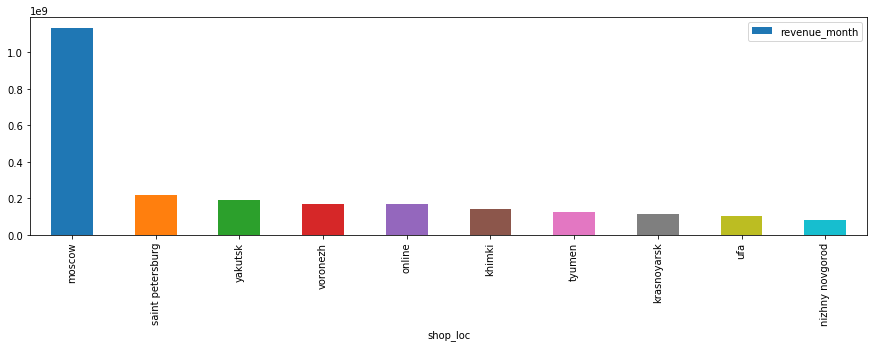

In [145]:
draw_sorted_barplot_with_groupby('shop_loc', 'revenue_month', 
                                 sum, idx=(None,10), figsize=(15,4))

## Number of unique `shop_id`s by `shop_loc`

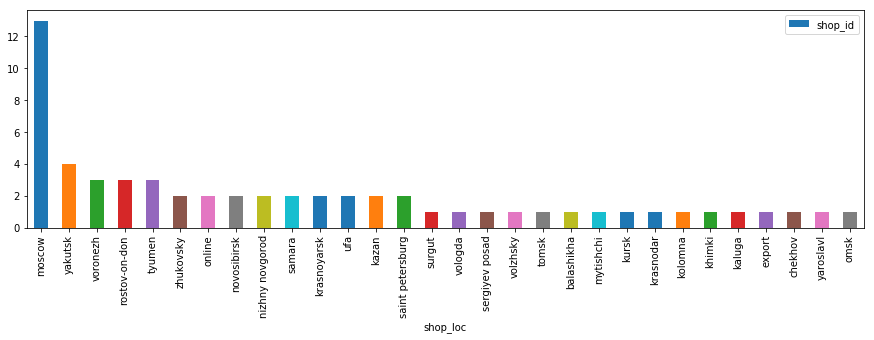

In [146]:
draw_sorted_barplot_with_groupby('shop_loc', 'shop_id', 
                                 lambda x: len(x.unique()), idx=(None,None), figsize=(15,4))

## Top 10 areas with total `revenue` per shop

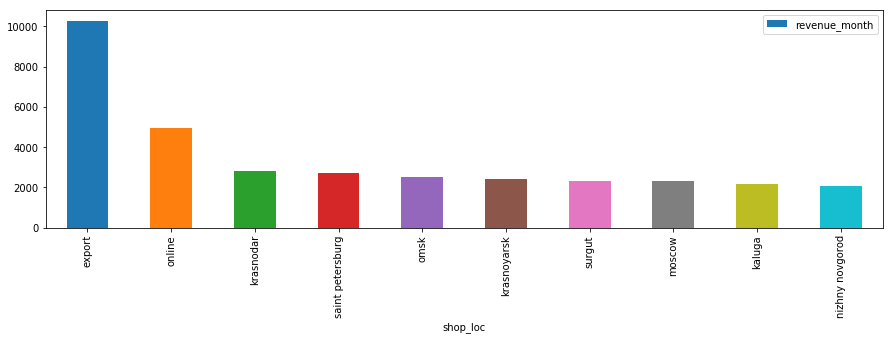

In [147]:
draw_sorted_barplot_with_groupby('shop_loc', 'revenue_month', 
                                 lambda x: x.mean(), idx=(None,10), figsize=(15,4))

### Top 10 areas with total `revenue` per shop 
### If excluding `export` and `online`

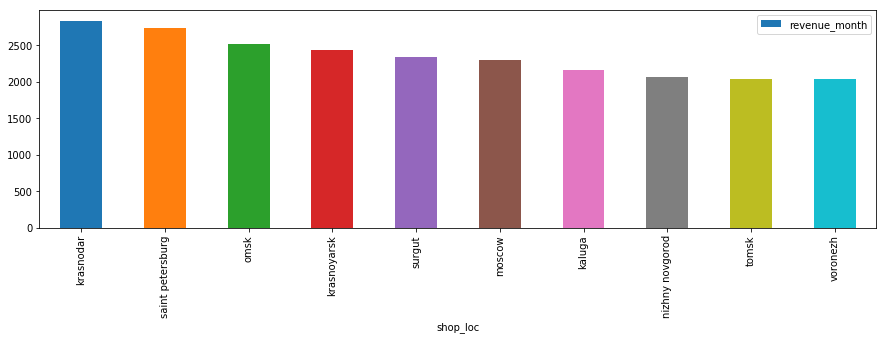

In [148]:
draw_sorted_barplot_with_groupby('shop_loc', 'revenue_month', 
                                 lambda x: x.mean(), idx=(2,12), figsize=(15,4))

## Top 10 shops in terms of `revenue`

In [17]:
total_revenue_by_store = train.groupby('shop_id')['revenue_month'].sum().sort_values(ascending=False)
plt.figure(figsize=(15, 5))
total_revenue_by_store[:10]

shop_id
31    235595600.0
25    216867424.0
28    159948672.0
42    152203136.0
54    142133440.0
27    140757120.0
12    116575208.0
57    113132040.0
6      98277800.0
18     83525976.0
Name: revenue_month, dtype: float32

In [162]:
top10shop_locs = [train[train['shop_id'] == topshop_id]['shop_loc'].unique()[0] for topshop_id in total_revenue_by_store[:10].index]
top10shop_locs

['moscow',
 'moscow',
 'moscow',
 'saint petersburg',
 'khimki',
 'moscow',
 'online',
 'yakutsk',
 'voronezh',
 'krasnoyarsk']

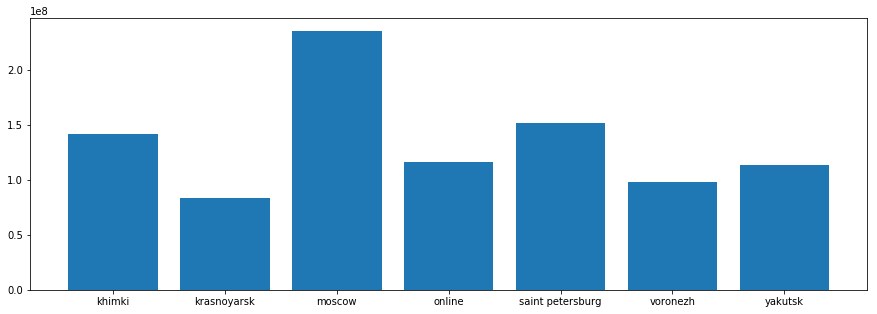

In [171]:
plt.figure(figsize=(15,5))
plt.bar(top10shop_locs, height=total_revenue_by_store[:10])
plt.show()

## What category has been sold in terms of `revenue`?

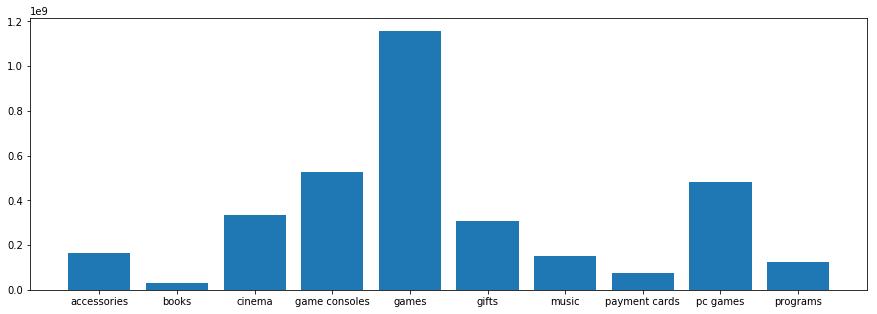

In [35]:
total_revenue_by_loc = train.groupby('item_first_category')['revenue_month'].sum().sort_values(ascending=False)
plt.figure(figsize=(15,5))

plt.bar(total_revenue_by_loc.reset_index()['item_first_category'][:10], 
        height=total_revenue_by_loc.reset_index()['revenue_month'][:10])
plt.show()

## What category has been sold in terms of `amount being sold`?

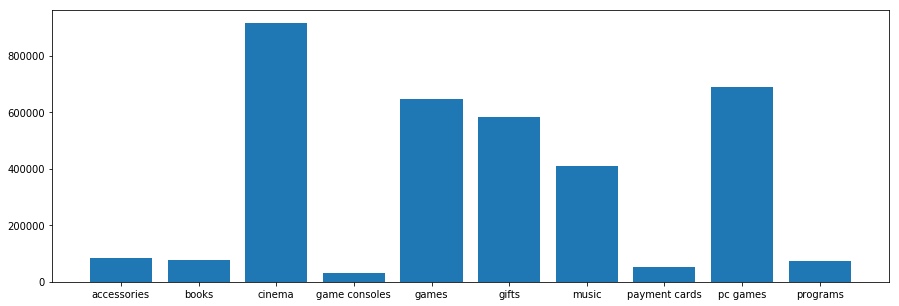

In [138]:
total_revenue_by_loc = train.groupby('item_first_category')['item_cnt_month'].sum().sort_values(ascending=False)
plt.figure(figsize=(15,5))

plt.bar(total_revenue_by_loc.reset_index()['item_first_category'][:10], 
        height=total_revenue_by_loc.reset_index()['item_cnt_month'][:10])
plt.show()

## If we categorize top sales shops by their major products?

In [55]:
shop_item_category_sales = train.groupby(['shop_id', 'item_first_category'])['revenue_month'].sum()
major_categories = []

for shopid in range(60):
    top3_items = shop_item_category_sales[shopid].sort_values(ascending=False).index.tolist()[:3]
    major_categories.append(top3_items)
    
# top3 item categories by their sales for each store (id)
dict(zip(range(60), major_categories))

{0: ['games', 'game consoles', 'cinema'],
 1: ['games', 'game consoles', 'cinema'],
 2: ['games', 'game consoles', 'pc games'],
 3: ['games', 'game consoles', 'pc games'],
 4: ['games', 'pc games', 'game consoles'],
 5: ['games', 'game consoles', 'pc games'],
 6: ['games', 'pc games', 'game consoles'],
 7: ['games', 'game consoles', 'pc games'],
 8: ['games', 'pc games', 'cinema'],
 9: ['gifts', 'games', 'pc games'],
 10: ['games', 'pc games', 'game consoles'],
 11: ['games', 'game consoles', 'pc games'],
 12: ['games', 'game consoles', 'pc games'],
 13: ['cinema', 'games', 'music'],
 14: ['games', 'pc games', 'game consoles'],
 15: ['games', 'pc games', 'game consoles'],
 16: ['games', 'game consoles', 'pc games'],
 17: ['games', 'game consoles', 'cinema'],
 18: ['games', 'game consoles', 'pc games'],
 19: ['games', 'pc games', 'game consoles'],
 20: ['gifts', 'books', 'elements of a food'],
 21: ['games', 'game consoles', 'cinema'],
 22: ['games', 'programs', 'pc games'],
 23: ['pc g

## Short-term trends over certain categories?

* Definition of `being trend`
  * ~~

## Case for item_id `6675` --- relationship among `revenue` & `price` & `num of sold`
* To visualize the inter-relationship, normalize each column and plot.

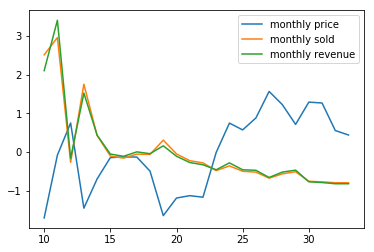

In [260]:
# by month (cumulative)
item_6675_mean_price_by_month = train[train['item_id'] == 6675][['item_price', 'date_block_num']].groupby('date_block_num')['item_price'].mean()
item_6675_total_num_sold_by_month = train[train['item_id'] == 6675][['item_cnt_day', 'date_block_num']].groupby('date_block_num')['item_cnt_day'].sum()
item_6675_total_rev_by_month = train[train['item_id'] == 6675][['revenue', 'date_block_num']].groupby('date_block_num')['revenue'].sum()

date_block_num_unique = item_6675_mean_price_by_month.index

def norm(series):
    return (series - series.mean())/series.std()

plt.plot(date_block_num_unique, norm(item_6675_mean_price_by_month), label='monthly price')
plt.plot(date_block_num_unique, norm(item_6675_total_num_sold_by_month), label='monthly sold')
plt.plot(date_block_num_unique, norm(item_6675_total_rev_by_month), label='monthly revenue')
plt.legend()
plt.show()

In [189]:
item_6675_total_num_sold_by_month.mean()

428.70833333333331

In [261]:
item_6675_total_num_sold_by_month

date_block_num
10    1764
11    2002
12     283
13    1359
14     654
15     370
16     341
17     396
18     392
19     589
20     399
21     306
22     275
23     169
24     234
25     160
26     148
27      65
28     124
29     154
30      22
31      14
32       2
33       2
Name: item_cnt_day, dtype: int64

## Insights in the case of `item_id = 6675`

* Interestingly, we can find a strong relationship between `monthly revenue` and `monthly number of sold`
* In contrast, there seems relateively low relationship between `monthly revenue` and `monthly price`

### We can consider an additional factor for each product - **`Price Elasticity of Demand`**
* For products with high price elasticity of demand:
  * The changes in price affect the demand
* For products with low price elasticity of demand
  * The changes in price don't affect the demand
  
### One more step - we can categorize the type of each product in terms of `Price Elasticity of Demand` 
* Essential goods --- low price elasticity of demand
* Luxury --- high price elasticity of demand
* We can 


In [161]:
print(train['item_first_categry'].unique().tolist())

['cinema', 'music', 'games', 'pc games', 'programs', 'books', 'gifts', 'accessories', 'game consoles', 'payment cards', 'clean media (piece)', 'clean carriers (spire)', 'office', 'pc', 'elements of a food', 'delivery of goods', 'movies', 'tickets (digital)', 'android games', 'mac games', 'official']


![](https://wikimedia.org/api/rest_v1/media/math/render/svg/3dc579ea00e87263d839bac3f1cdeb37937f70a4)

In [184]:
train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id,shop_loc,shop_loc_dist,shop_loc_pop_2010,shop_loc_pop_2017,shop_loc_pop_rank_2017,shop_loc_pop_change_2010_2017,item_first_categry,item_second_categry,date_month,date_year,revenue,date_yearmonth,date_season
0,2013-02-01,0,59,22154,999.000000,1,37,yaroslavl,Central,591486.0,608079.0,25.0,2.8,cinema,blu-ray,2,2013,999.000000,201302,winter
1,2013-03-01,0,25,2552,899.000000,1,58,moscow,Central,11503501.0,12228685.0,1.0,6.3,music,vinyl,3,2013,899.000000,201303,spring
2,2013-05-01,0,25,2552,899.000000,-1,58,moscow,Central,11503501.0,12228685.0,1.0,6.3,music,vinyl,5,2013,-899.000000,201305,spring
3,2013-06-01,0,25,2554,1709.050049,1,58,moscow,Central,11503501.0,12228685.0,1.0,6.3,music,vinyl,6,2013,1709.050049,201306,summer
4,2013-01-15,0,25,2555,1099.000000,1,56,moscow,Central,11503501.0,12228685.0,1.0,6.3,music,cd of branded production,1,2013,1099.000000,201301,winter


## Considering factor `'Seasonality'`

* Some products have seasonal sales patterns - the others got sold in a limited period.
* We can determine which product is seasonal or not
  * And create a column to represent the information.

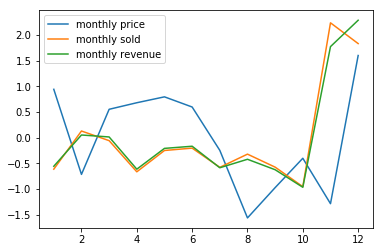

In [262]:
# by month (absolute)
item_6675_mean_price_by_month = train[train['item_id'] == 6675][['item_price', 'date_month']].groupby('date_month')['item_price'].mean()
item_6675_total_num_sold_by_month = train[train['item_id'] == 6675][['item_cnt_day', 'date_month']].groupby('date_month')['item_cnt_day'].sum()
item_6675_total_rev_by_month = train[train['item_id'] == 6675][['revenue', 'date_month']].groupby('date_month')['revenue'].sum()

date_block_num_unique = item_6675_mean_price_by_month.index

def norm(series):
    return (series - series.mean())/series.std()

plt.plot(date_block_num_unique, norm(item_6675_mean_price_by_month), label='monthly price')
plt.plot(date_block_num_unique, norm(item_6675_total_num_sold_by_month), label='monthly sold')
plt.plot(date_block_num_unique, norm(item_6675_total_rev_by_month), label='monthly revenue')
plt.legend()
plt.show()

**However, the concept `'Seasonality'` could be more or less a narrow concept.**

## We can calculate `hot sales month index` 

grouping data by `date_block_num`, not by `date_month` - in this way, values of `hot sales month` column can represent information including seasonality as well.

* `more than twice` of the mean number of sold --- `month on trend`
* `less than half` of the mean number of sold --- `month out of trend`
  

In [140]:
train[train['item_id'] == 1][['item_price', 'date_block_num']].groupby('date_block_num')['item_price'].mean()

date_block_num
15    4490.0
18    4490.0
19    4490.0
20    4490.0
21    4490.0
Name: item_price, dtype: float32

In [117]:
train[(train['shop_id'] == 5) & (train['item_id'] == 6675)].groupby('date_yearmonth')['revenue'].sum()

date_yearmonth
201301     53970.000000
201306     18990.000000
201311    383790.000000
201312    321870.000000
201401     22990.000000
201402    113940.000000
201403    373830.003906
201404    257890.000000
201405    142940.000000
201406    193920.000000
201407    110352.000000
201408    129136.000000
201409    113345.000000
201410    249972.000000
201411     82960.000000
201412     24990.000000
201501     23491.000000
201502     24990.000000
201503     26490.000000
201504     23491.000000
201505     26990.000000
201509     24990.000000
201512     24591.000000
Name: revenue, dtype: float64

In [95]:
train.groupby('item_id')['revenue'].sum().sort_values(ascending=False)[:10]

item_id
6675     2.193915e+08
3732     4.361798e+07
13443    3.433125e+07
3734     3.106516e+07
3733     2.229886e+07
16787    2.190784e+07
3731     1.998348e+07
13405    1.812548e+07
17717    1.720083e+07
5823     1.715185e+07
Name: revenue, dtype: float64

In [ ]:
train['shop_id'].unique()

## Distribution of item prices
* 

In [32]:
from matplotlib import pyplot as plt

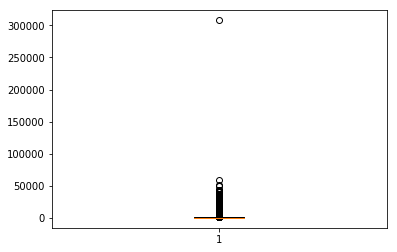

In [61]:
plt.boxplot(train['item_price'])
plt.show()

In [50]:
print(len(train[train['item_price']<1000]))
print(len(train[train['item_price']>=1000]))
train['item_price'].describe()

2269732
666117


count    2.935849e+06
mean     8.908532e+02
std      1.729800e+03
min     -1.000000e+00
25%      2.490000e+02
50%      3.990000e+02
75%      9.990000e+02
max      3.079800e+05
Name: item_price, dtype: float64

In [82]:
train['item_price'].value_counts()

pandas.core.series.Series

## Item price in over 75% of total sales record -> Less than `1000`
* Create column `item_price_range` to categorize the item prices by range for visualization and further modeling

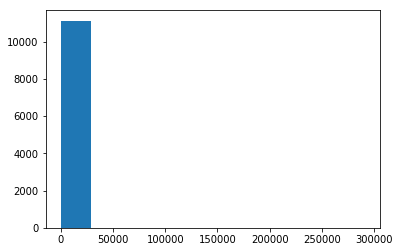

In [60]:
plt.hist(train[train['item_price'] < 1000]['item_price'].value_counts())
plt.show()

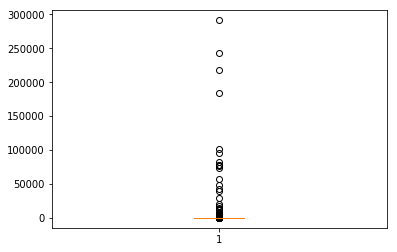

In [56]:
plt.boxplot(train[train['item_price'] < 1000]['item_price'].value_counts())
plt.show()

In [55]:
train[train['item_price'] < 1000]['item_price'].value_counts()

299.000000    291352
399.000000    242603
149.000000    218432
199.000000    184044
349.000000    101461
599.000000     95673
999.000000     82784
799.000000     77882
249.000000     77685
699.000000     76493
499.000000     73078
899.000000     57156
99.000000      48955
449.000000     43205
549.000000     39080
5.000000       29702
169.000000     20848
749.000000     17351
229.000000     14209
649.000000     12460
849.000000     12102
98.000000      11141
349.500000      9353
419.000000      8697
299.500000      7958
58.000000       7876
599.500000      7779
28.000000       7725
949.000000      7540
198.000000      5701
               ...  
174.184998         1
170.050003         1
172.466660         1
170.440002         1
170.679993         1
170.824997         1
171.071426         1
171.250000         1
171.289993         1
171.661804         1
171.666672         1
171.669998         1
172.025314         1
172.220001         1
172.333328         1
172.494995         1
174.169998   

In [ ]:
train['item_price_range1']

## Total sales by location (`shop_loc`) in the entire period

In [30]:
# total list of unique values in 'shop_loc' column

print(train['shop_loc'].unique().tolist())

['yaroslavl', 'moscow', 'kursk', 'krasnoyarsk', 'volzhsky', 'voronezh', 'krasnodar', 'balashikha', 'yakutsk', 'kolomna', 'kaluga', 'zhukovsky', 'kazan', 'online', 'ufa', 'nizhny novgorod', 'chekhov', 'khimki', 'surgut', 'tyumen', 'saint petersburg', 'rostov-on-don', 'omsk', 'samara', 'novosibirsk', 'sergiyev posad', 'vologda', 'export', 'tomsk', 'mytishchi']


In [ ]:
train.groupby('shop_loc')['']